In [81]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import trackpy as tp
import pandas as pd
import pims
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [82]:
# Load the video
cap = cv2.VideoCapture('low_angle.mov')
num_rotor = 29
size_thresh = 15
threshold_value = 60

features = pd.DataFrame(columns=['x', 'y', 'frame'])

# Define the threshold values for different frame ranges if needed
threshold_values = {
}

frame_num = 0

In [83]:
# if not cap.isOpened():
#     print("Error: Could not open video file.")
# else:
#     print("Video file opened successfully.")
#     ret, frame = cap.read()
#     # Check if the frame was successfully retrieved
#     if ret:
#         # Convert the frame from BGR to RGB (Matplotlib uses RGB)
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
#         # Display the frame using Matplotlib
#         plt.imshow(frame_rgb)
#         plt.axis('off')  # Turn off axis labels
#         plt.show()
#     else:
#         print("Error: Could not read the first frame.")
#     print("Cropping Frame:")
#     frame = frame[360:-330, 380:-370]
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     plt.imshow(gray, cmap='gray')
#     plt.axis('off')  # Turn off axis labels
#     plt.show()
#     ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
#     print("Applying Binary Threshold:")
#     plt.imshow(thresh, cmap='gray')
#     plt.axis('off')  # Turn off axis labels
#     plt.show()
#     print("Applying Gaussian Blur Filter:")
#     thresh = cv2.GaussianBlur(thresh, (3, 3), 0)
#     plt.imshow(thresh, cmap='gray')
#     plt.axis('off')  # Turn off axis labels
#     plt.show()


In [84]:
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
# print(f"{num_labels=} \n {labels=} \n {stats=} \n {centroids=}" )
# # Create a color map for labels (excluding the background label)
# colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

# # Create an output image to visualize the labels
# labeled_image = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

# # Map the labels to colors
# for label in range(num_labels):
#     labeled_image[labels == label] = colors[label]

# # Convert BGR to RGB for Matplotlib
# labeled_image_rgb = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)

# # Display the result using Matplotlib
# plt.figure(figsize=(10, 10))
# plt.imshow(labeled_image_rgb)
# plt.title('Labeled Image')
# plt.axis('off')  # Turn off axis
# plt.show()

Frame 778: 28


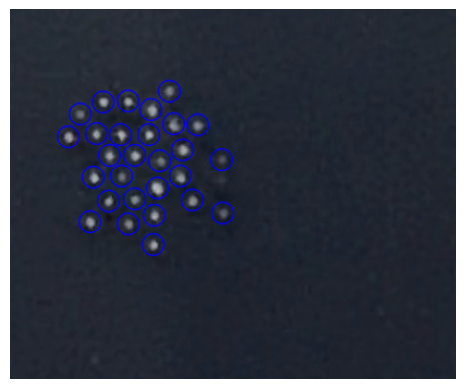

Frame 1032: 28


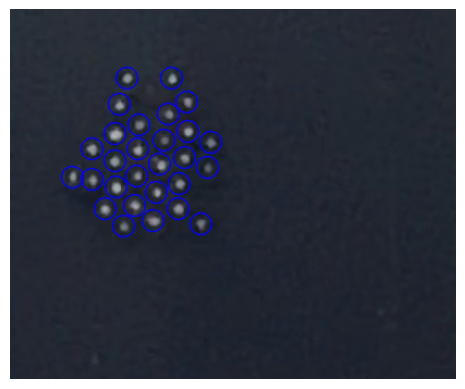

Frame 1055: 30


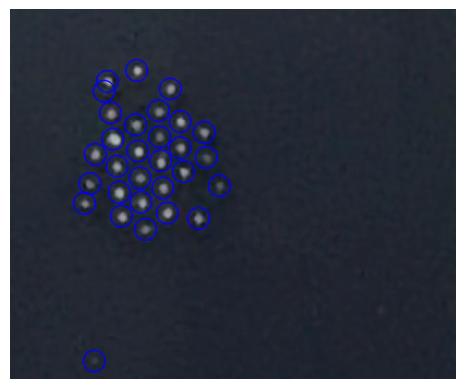

Frame 1073: 28


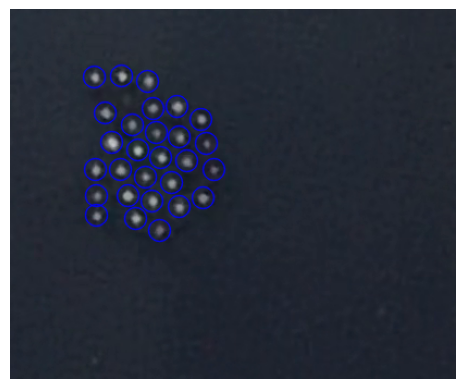

Frame 1513: 30


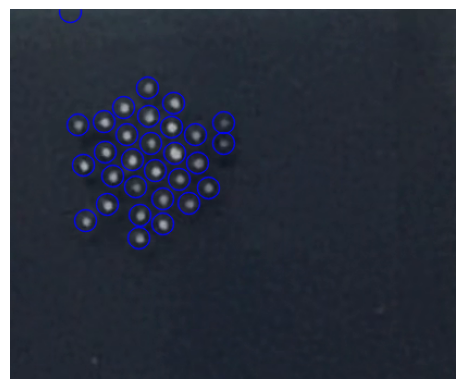

Frame 1525: 30


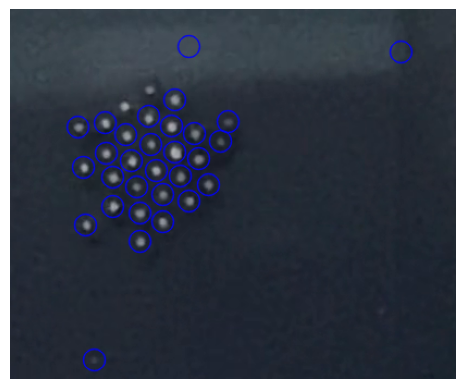

Frame 1529: 28


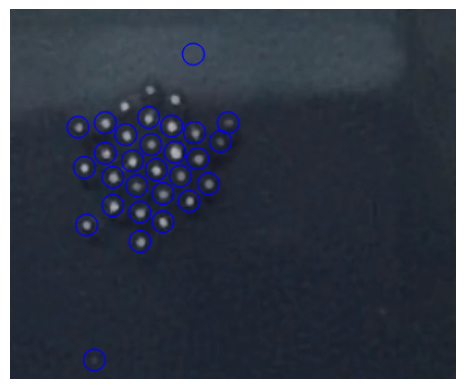

Frame 1534: 32


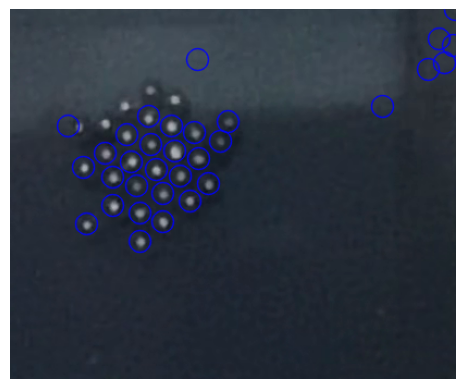

Frame 1535: 30


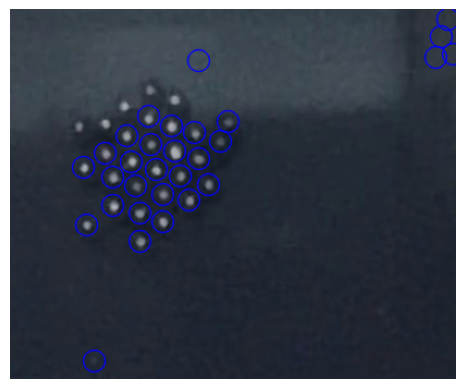

Frame 1543: 30


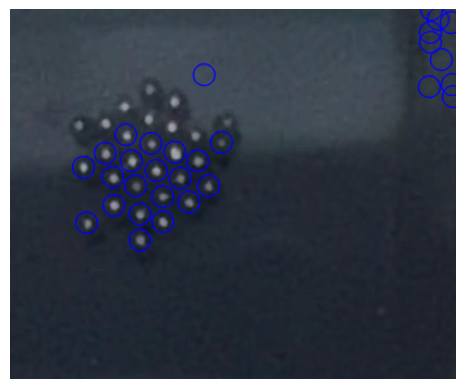

Frame 1547: 30


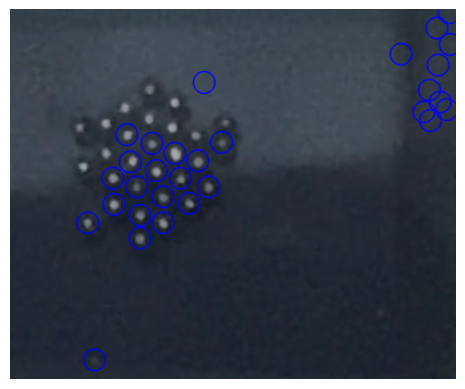

Frame 1550: 31


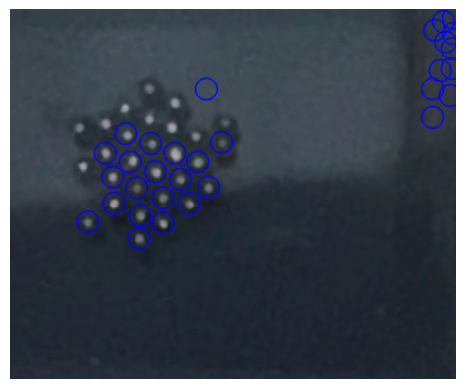

Frame 1554: 31


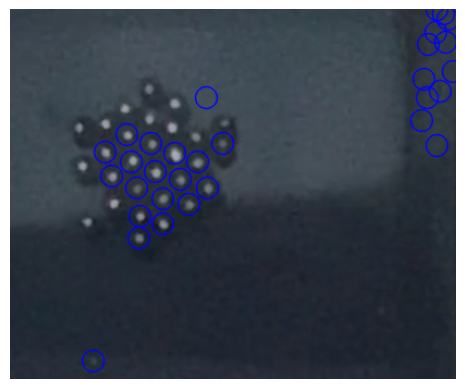

Frame 1559: 33


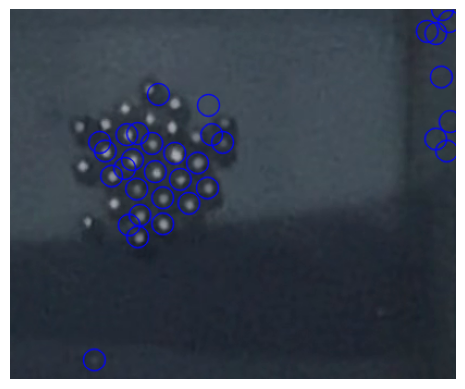

Frame 1560: 30


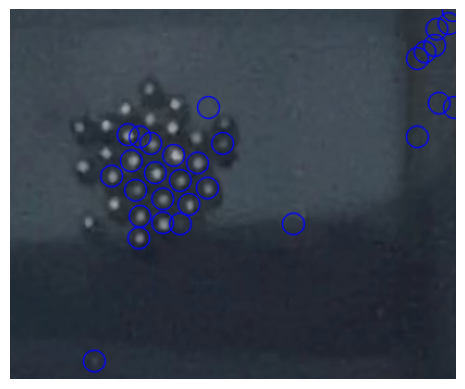

Frame 1561: 30


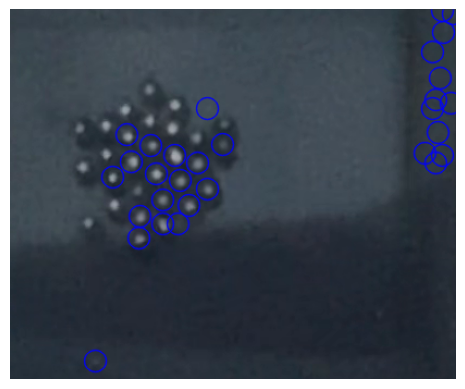

Frame 1563: 30


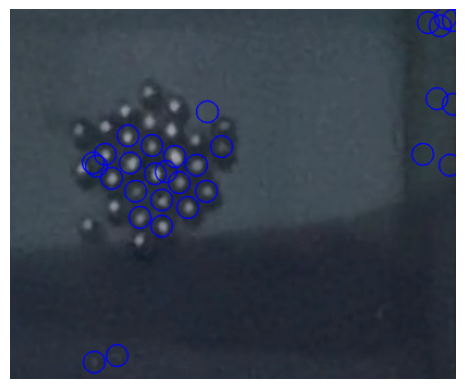

Frame 1564: 30


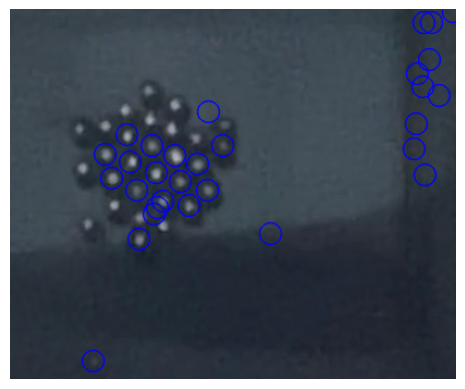

total error frame:18


In [85]:
error_counter = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    # 1. Crop
    frame = frame[1050:-2450,650:-1100]
    # 2. Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Determine the threshold value based on the frame number

    # for frame_range, (threshold_value, size_thresh) in threshold_values.items():
    #     start_frame, end_frame = frame_range
    #     if start_frame <= frame_num <= end_frame:
    #         break
    # else:
    #     # If the frame number is not in any defined range, use a default threshold value
    #     threshold_value = 150
    #     size_thresh = size_thresh


    # Threshold the frame to get the white dots
    ret, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    thresh = cv2.GaussianBlur(thresh, (3, 3), 0)

    # # Erode the image to remove small noise
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.erode(thresh,kernel,iterations=1)

    # Find connected components in the thresholded frame
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    current_rotor_count = 0
    
    area_ls = stats[:, cv2.CC_STAT_AREA][1:]
    # print(f"{area_ls=}")
    mean_area = np.median(area_ls)
    # print(f"{mean_area=}")
    std_area = np.std(area_ls)
    # print(f"{mean_area=}",f"{std_area=}")
    upper_size_thresh = mean_area + 3*std_area
    lower_size_thresh = mean_area - 3*std_area # (2->800; 3-> 303; original -> )
    # index_30 = np.min([len(area_ls)-1,29])
    index_30 = np.min([len(area_ls)-1,28])
    size_30 = -np.sort(-area_ls)[index_30]
    # print(f"{lower_size_thresh=} || {upper_size_thresh=}")

    # Iterate through each component and find the centroid
    # Starting from 1 because 0 is brackground
    for i in range(1, num_labels):
        # Check if the size of the component is greater than the threshold
        
        size_i = stats[i, cv2.CC_STAT_AREA]
        # if size_i > size_thresh:
        if size_i >= size_30:
        # if size_i > lower_size_thresh:
            cx = int(centroids[i][0])
            cy = int(centroids[i][1])
            features = pd.concat([features,pd.DataFrame({'x': [cx], 'y': [cy], 'frame': [frame_num]
            })],ignore_index=True)
            # Draw a hollow circle at the centroid with a diameter of 10 pixels
            cv2.circle(frame, (cx, cy), 10, (0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            current_rotor_count += 1
    
    print(f"\rFrame {frame_num}", end='', flush=True)
    if current_rotor_count < num_rotor or current_rotor_count > num_rotor:
        print(':', current_rotor_count)
        error_counter+=1
        plt.imshow(frame)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        
    frame_num += 1

# Release the video and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
print(f"total error frame:{error_counter}")


In [ ]:
# Define parameters for linking
search_range = 15   # max distance a particle can move between frames
memory = 5         # number of frames a particle can disappear and still be considered the same
frame_thresh = 5; # number of frames a particle have to appear more than or else will be filtered

# Link the detected features
trajectories = tp.link_df(features, search_range=search_range, memory=memory)

# Count the occurrences of each particle
particle_counts = trajectories['particle'].value_counts()

# Filter out particles that appear fewer than frame_thresh times
valid_particles = particle_counts[particle_counts >= frame_thresh].index
filtered_trajectories = trajectories[trajectories['particle'].isin(valid_particles)]

# Sort particles by their frequency of appearance in descending order
particle_sorted = particle_counts[particle_counts >= 5].sort_values(ascending=False)

# Create a mapping from old particle IDs to new sorted IDs
new_particle_ids = {old_id: new_id + 1 for new_id, old_id in enumerate(particle_sorted.index)}

# Reassign particle IDs based on their sorted order
filtered_trajectories['particle'] = filtered_trajectories['particle'].map(new_particle_ids)

# Save the filtered DataFrame with valid particles to Excel
filtered_trajectories.to_excel('filtered_trajectory_low_angle.xlsx', index=False)

# Save the data to Excel files
# features.to_excel('f_30rotors_5wt_1.3T_5mm_60fps_iphone.xlsx', index=False)
# trajectories.to_excel('trajectory_range_30_mem_5.xlsx', index=False)

Frame 1564: 30 trajectories present.


/var/folders/wz/j9lnc2k16rj459k4ppbs86y40000gn/T/ipykernel_12031/4042187017.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trajectories['particle'] = filtered_trajectories['particle'].map(new_particle_ids)


In [ ]:
def trshow(tr, first_style='bo', last_style='ro', style='none'):
    frames = list(tr.groupby('frame'))
    nframes = len(frames)
    for i, (fnum, pts) in enumerate(frames):
        if i == 0:
            sty = first_style
            for pid, x, y in zip(pts['particle'], pts.x, pts.y):
                plt.annotate(pid, (x, y), fontsize=12)
        elif i == nframes - 1:
            sty = last_style
            for pid, x, y in zip(pts['particle'], pts.x, pts.y):
                plt.annotate(pid, (x, y), fontsize=8)
        else:
            sty = style
        plt.plot(pts.x, pts.y, sty)
    if 'particle' in tr.columns:
        for pid in tr.particle.unique():
            color = cm.viridis(np.linspace(0, 1, nframes))
            #plt.plot(tr.x[tr.particle == pid], 
                     #tr.y[tr.particle == pid], color=color)
            #color = cm.viridis(np.linspace(0, 1, nframes))
            tr_particle = tr[tr.particle == pid]
            #sc = plt.scatter(tr_particle.x, tr_particle.y, c=color[tr_particle.frame], cmap='viridis', s=5)
    #ylim(-11, 11)
    plt.xlabel('x [px]')
    plt.ylabel('y [px]')
#     plt.xlim(25,175)
#     plt.ylim(210,60) 
    #cbar = plt.colorbar(sc)
    #cbar.set_label('Time')

# Use the link_df function with the Linker object
tp.linking.Linker.MAX_SUB_NET_SIZE = num_rotor + 5
t = tp.link_df(features, search_range=25, memory=5)

# cap = cv2.VideoCapture('s_30mesogens_500rpm_500fps_10s_1.mp4')
# frame_number = 0
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
# ret, img = cap.read()
# img=img[350:-400, 425:-325] 

plt.figure(figsize=[6,6])
#tp.plot_traj(t)
#tp.plot_traj(t, superimpose=img)
plt.figure(figsize=[6,6])
trshow(t)
t.head()

In [ ]:
print(t)
t_filtered = tp.filter_stubs(t, threshold=7499) # 7499
print("After Filtering:")
print(t_filtered)

In [ ]:
t_filtered.to_excel('f_30rotors_5wt_1.3T_5mm_high_50fps_0-150s.xlsx', index=False)

In [ ]:
def fill_missing_particles(df):
    
    df = df.reset_index(drop=True)
    # Count the number of particles in each frame
    frame_counts = df.groupby('frame').particle.nunique()
    # Identify frames with fewer than 30 particles
    missing_frames = frame_counts[frame_counts < 30].index

    for frame in missing_frames:
        prev_frame, next_frame = frame - 1, frame + 1

        # Identify missing particles
        current_particles = set(df[df['frame'] == frame]['particle'])
        prev_particles = set(df[df['frame'] == prev_frame]['particle'])
        next_particles = set(df[df['frame'] == next_frame]['particle'])
        missing_particles = (prev_particles & next_particles) - current_particles

        for particle in missing_particles:
            # Calculate average position
            prev_pos = df[(df['frame'] == prev_frame) & (df['particle'] == particle)][['x', 'y']].values[0]
            next_pos = df[(df['frame'] == next_frame) & (df['particle'] == particle)][['x', 'y']].values[0]
            avg_pos = (prev_pos + next_pos) / 2

            print(f'Frame: {frame}, Particle: {particle}')
            print(f'Previous Position: {prev_pos}')
            print(f'Next Position: {next_pos}')
            print(f'Average Position: {avg_pos}')

            # Append the new row to the DataFrame
            new_row = pd.DataFrame({'frame': [frame], 'particle': [particle], 'x': [avg_pos[0]], 'y': [avg_pos[1]]})
            df = pd.concat([df, new_row], ignore_index=True)

    return df.sort_values(by=['frame', 'particle']).reset_index(drop=True)

# Apply the function to the DataFrame
filled_df = fill_missing_particles(t_filtered)
print(filled_df)

In [ ]:
filled_df.to_excel('f_30rotors_5wt_1.3T_5mm_low_50fps_0-150s.xlsx', index=False)